## Sample nuisance parameters in eBOSS P1D measurement

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

### Set up data (eBOSS P1D measurement from Chabanier et al. 2019)

In [2]:
zmin=2.7
zmax=3.3
plot_every_iz=1

In [3]:
data=data_Chabanier2019.P1D_Chabanier2019(zmin=zmin,zmax=zmax)

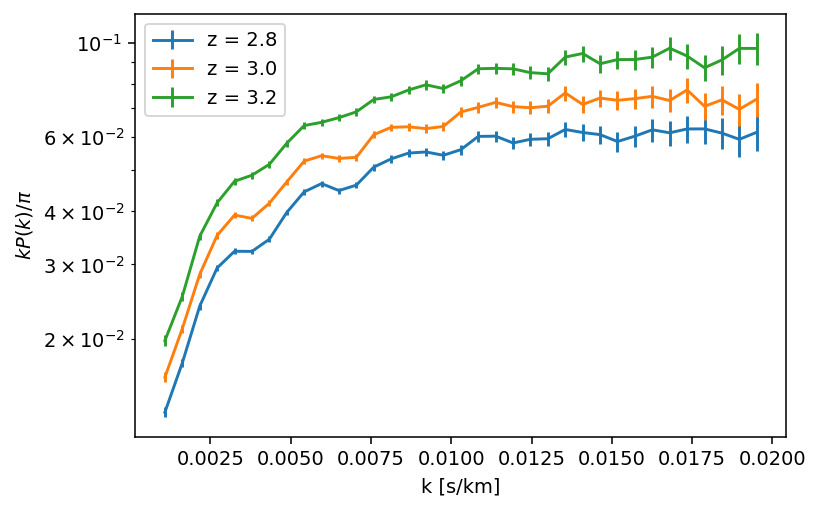

In [4]:
data.plot_p1d()

### Set up high-res extra data (P1D measurement from Karacayli et al. 2022)

Nz = 15 , Nk = 21


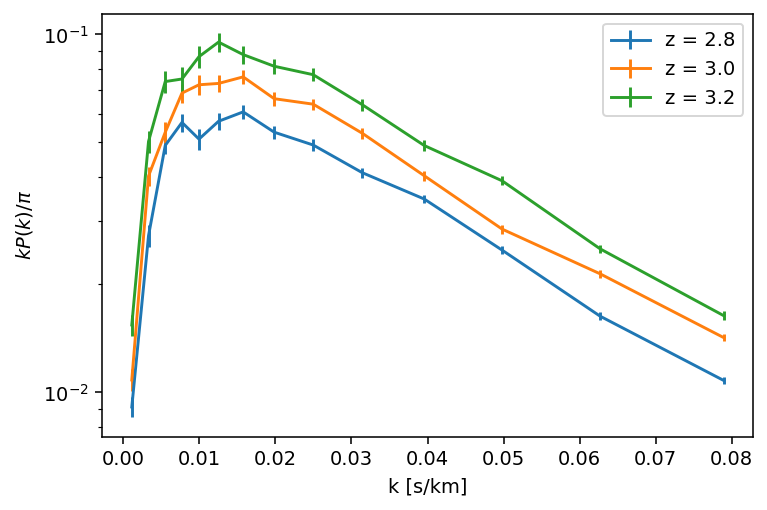

In [5]:
add_hires=True
if add_hires:
    extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=zmin,zmax=zmax)
    extra_data.plot_p1d()
    emu_kmax_Mpc=8
    emu_ndeg=7
else:
    extra_data=None
    emu_kmax_Mpc=4
    emu_ndeg=5

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [6]:
emulator_label="LaCE-GP"
if emulator_label=="LaCE-GP":
#    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
    emulator=gp_emulator.GPEmulator(training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
elif emulator_label=="LaCE-NN":
    assert not add_hires,"NN emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    assert not add_hires,"Nyx emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Pedersen21
Selected custom emulator
Training GP on 330 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.27 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [8]:
# add metal line contaminations
free_param_names.append('ln_SiIII_0')

In [9]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

metal tag ln_SiIII


In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                           free_param_names=free_param_names,
                           prior_Gauss_rms=prior_Gauss_rms,
                           emu_cov_factor=emu_cov_factor,
                           extra_p1d_data=extra_data)

will not store truth, working with real data
will not store truth, working with real data


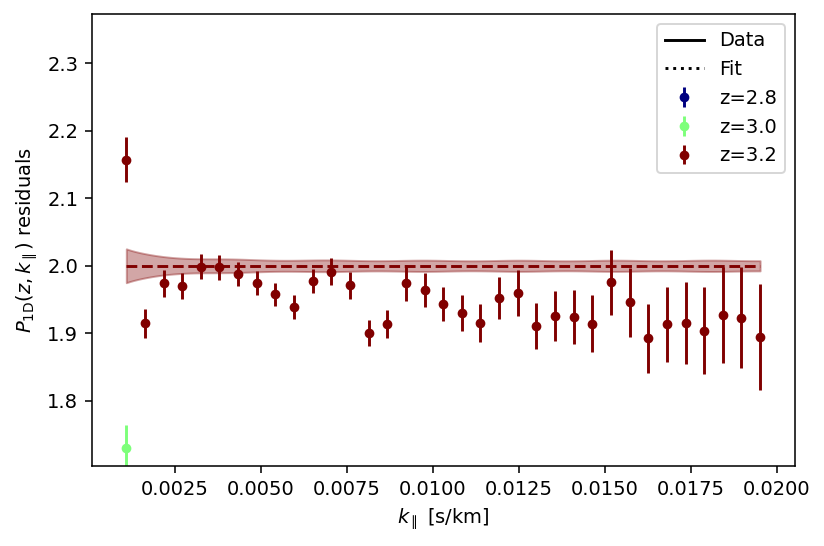

In [11]:
like.plot_p1d(residuals=True,plot_every_iz=1)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [12]:
# Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,progress=True)

Created directory: /Users/font/Codes/igmhub/cup1d//chains//chain_32
setup with 20 walkers


In [13]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 0.0 -0.1 0.1
ln_sigT_kms_0 0.0 -0.4 0.4
ln_gamma_0 0.0 -0.2 0.2
ln_kF_0 0.0 -0.2 0.2
ln_SiIII_0 -4.509860006183767 -20 0


In [ ]:
n_burn_in=200
n_steps=10000
start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

 63%|██████████████████████▋             | 6425/10200 [1:12:16<39:26,  1.60it/s]

In [ ]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

In [ ]:
if free_cosmo:
    sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)

In [ ]:
sampler.plot_corner(plot_params=['$\\mathrm{ln}\\,\\tau_0$','$\\mathrm{ln}\\,f^{SiIII}_0$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)

In [ ]:
sampler.plot_corner(plot_params=['$\\mathrm{ln}\\,\\tau_0$','$\\mathrm{ln}\\,\\gamma_0$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)